In [245]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.geo import center_track_pos_and_time_based_on_data_batched_v
from lib.experimental_methods import get_clean_pulses_fn_v
from lib.network import get_network_eval_v_fn

from likelihood_mpe_padded_input import get_neg_c_triple_gamma_llh
from lib.geo import get_xyz_from_zenith_azimuth, __c
from dom_track_eval import get_eval_network_doms_and_track2 as get_eval_network_doms_and_track
import time

dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

# Create padded batches (with different seq length).
event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']

ix = 19
print(event_ids[ix])
tfrecord = f"/home/storage2/hans/i3files/alerts/bfrv2/event_{event_ids[ix]}_N100_from_0_to_10_1st_pulse.tfrecord"



#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_CloseToDOMs_Smooth_N100_from_0_to_10_1st_pulse.tfrecord"
#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_CloseToDOMs_Stochastic_N100_from_0_to_10_1st_pulse.tfrecord"
# ridiculous pulse: 2063.8000043034554pe
# ridiculous pulse 97pe

#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_FarFromDOMs_Stochastic_N100_from_0_to_10_1st_pulse.tfrecord"
#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_FarFromDOMs_Smooth_N100_from_0_to_10_1st_pulse.tfrecord"
# ridiculous pulse: 2063.8000043034554pe
# ridiculous pulse 97pe

batch_maker = I3SimBatchHandlerTFRecord(tfrecord, batch_size=100)
batch_iter = batch_maker.get_batch_iterator()

# Until LLH has a noise-term, we need to remove crazy early noise pulses
clean_pulses_fn_v = get_clean_pulses_fn_v(eval_network_doms_and_track)

data, mctruth = batch_iter.next()
data = jnp.array(data.numpy())
mctruth = jnp.array(mctruth.numpy())
data_clean_padded = clean_pulses_fn_v(data, mctruth)

track_times = mctruth[:, 4]
track_positions = mctruth[:, 5:8]
track_srcs = mctruth[:,2:4]

21113


In [246]:
track_times_ = track_times.reshape((len(track_times), 1))

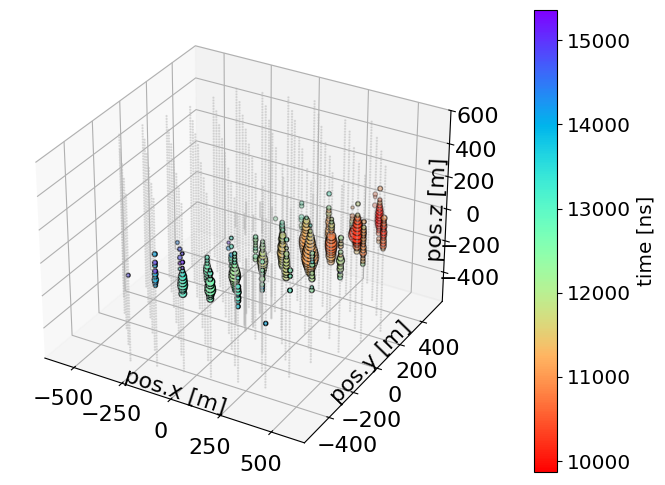

In [247]:
geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
pulses = data_clean_padded[0]
df = pd.DataFrame(data=pulses, columns = ["x", "y", "z", "time", "charge"])

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

In [248]:
hit_x = np.array(data_clean_padded[..., 0].flatten())
hit_y = np.array(data_clean_padded[..., 1].flatten())
hit_z = np.array(data_clean_padded[..., 2].flatten())
hit_t = np.array((data_clean_padded[..., 3]-track_times_).flatten())
hit_q = np.array(data_clean_padded[..., 4].flatten())

In [249]:
from collections import defaultdict
times_dict = defaultdict(list)
charges_dict = defaultdict(list)

for i in range(len(hit_x)):
    q = hit_q[i]
    if q < 1.e-3:
        continue

    if q > 1000:
        continue
        
    x = hit_x[i]
    y = hit_y[i]
    z = hit_z[i]
   
    t = hit_t[i]
    times_dict[(x,y,z)].append(t)
    charges_dict[(x,y,z)].append(q)

qtot_dict = dict()
for key, qs in charges_dict.items():
    qtot_dict[key]=sum(qs) / len(qs)

In [250]:
max_om = max(qtot_dict, key=charges_dict.get)

In [251]:
print(qtot_dict[max_om])

249.13697919249535


In [252]:
print(charges_dict[max_om])

[244.07499980926514, 232.72500103712082, 272.67499651014805, 251.54999700188637, 219.74999886751175, 233.82499808073044, 237.87500140070915, 218.0999974310398, 251.14999994635582, 239.15000090003014, 238.6999987512827, 235.9999995827675, 258.84999972581863, 270.4249994754791, 218.77500066161156, 278.62500113248825, 249.92499747872353, 240.52500250935555, 272.30000200867653, 249.200001090765, 207.57499906420708, 250.77500069141388, 254.47499784827232, 286.3500045835972, 221.50000140070915, 235.92499986290932, 248.25000154972076, 235.22499719262123, 251.2249995470047, 275.67500126361847, 249.9750006198883, 244.6500028371811, 270.72499507665634, 275.1499994844198, 247.57499825954437, 270.8249989449978, 256.49999898672104, 255.7999985218048, 262.77500131726265, 246.5750012099743, 241.9499997496605, 236.0999988913536, 256.02499800920486, 273.9749998152256, 250.0000001192093, 260.3499988913536, 251.02499863505363, 279.50000044703484, 241.30000349879265, 247.69999688863754, 262.87500044703484

In [253]:
print(times_dict[max_om])
print(np.min(times_dict[max_om]))
print(np.max(times_dict[max_om]))
print(np.std(times_dict[max_om]))

[14052.089535145384, 14048.25282173116, 14051.801158392671, 14052.25452305664, 14049.616970211744, 14054.800595460809, 14054.564169618661, 14047.765222553655, 14054.268995487215, 14048.393842172827, 14048.146454202975, 14046.724943163274, 14051.046236129478, 14054.373771317223, 14048.726243903817, 14049.636252153428, 14050.900809291452, 14051.792305337105, 14047.965423121168, 14053.059361026819, 14048.356656519161, 14045.228742467578, 14050.127527334182, 14048.925730414641, 14049.461057968812, 14052.849152608822, 14050.458607654447, 14050.522681352206, 14051.291632418652, 14049.351315474312, 14046.348328281729, 14049.501570761895, 14048.754673724354, 14050.37222051675, 14048.226883929907, 14051.787267490567, 14055.966730888398, 14049.618243571098, 14051.32480119995, 14056.802980153712, 14049.551309607159, 14052.494983429726, 14050.295715548677, 14051.432499054245, 14052.925937238524, 14050.645640799907, 14047.484169538526, 14049.553641226186, 14048.64016948895, 14051.46561176745, 14047

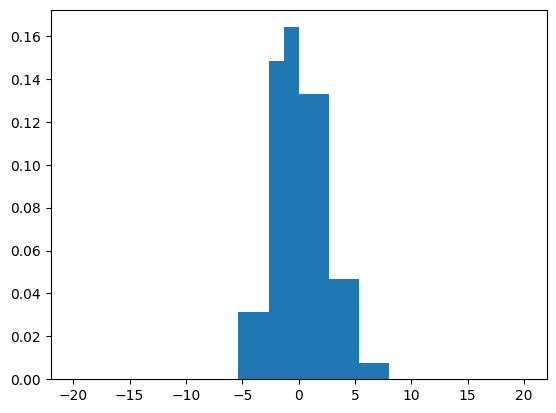

In [254]:
plt.hist(times_dict[max_om]-np.median(times_dict[max_om]), bins=np.linspace(-20, 20, 31), density=True)
plt.show()

In [255]:
positions_batch = []
for key in times_dict.keys():
    positions_batch.append(jnp.array(key).reshape((1,3)))

positions_batch = jnp.concatenate(positions_batch, axis=0)

In [256]:
logits, av, bv, geo_time = eval_network_doms_and_track(positions_batch, track_positions[0], track_srcs[0])
mix_probs = jax.nn.softmax(logits)

In [257]:
for i in range(len(positions_batch)):
    pos = tuple(np.array(positions_batch[i]))
    gt = geo_time[i]
    for j in range(len(times_dict[pos])):
        times_dict[pos][j] -= float(gt)

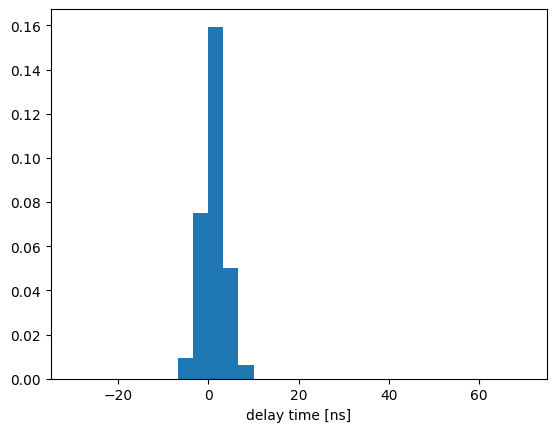

2.367285932815387


In [258]:
plt.hist(times_dict[max_om], bins=np.linspace(-30, 70, 31), density=True)
plt.xlabel('delay time [ns]')
plt.show()

print(np.std(times_dict[max_om]))

In [259]:
print(times_dict[max_om])

[3.216855745200519, -0.6198576690239861, 2.928478992487726, 3.3818436564561125, 0.7442908115608589, 5.927916060625648, 5.691490218478066, -1.1074568465282937, 5.396316087031664, -0.4788372273560526, -0.7262251972078957, -2.1477362369096227, 2.1735567292944324, 5.5010919170399575, -0.14643549636639364, 0.763572753245171, 2.0281298912686907, 2.919625936921875, -0.9072562790152006, 4.186681626635618, -0.5160228810218541, -3.6439369326053566, 1.2548479339984624, 0.05305101445810578, 0.5883785686291958, 3.9764732086387085, 1.5859282542642177, 1.6500019520226488, 2.418953018468528, 0.47863607412909914, -2.524351118454433, 0.6288913617117942, -0.11800567582940857, 1.4995411165673431, -0.6457954702764255, 2.914588090383404, 7.094051488214973, 0.745564170914804, 2.452121799766246, 7.930300753529082, 0.6786302069758676, 3.622304029542647, 1.4230361484933383, 2.559819654061357, 4.053257838340869, 1.7729613997234992, -1.3885098616574396, 0.680961826003113, -0.23250991123313725, 2.5929323672662576,

In [260]:
from lib.geo import cherenkov_cylinder_coordinates_w_rho2_v as cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth

In [261]:
track_dir_xyz = get_xyz_from_zenith_azimuth(track_srcs[0])

geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(positions_batch,
                                         track_positions[0],
                                         track_dir_xyz)

In [262]:
print(closest_approach_dist)

[236.69753693 211.20957821 177.60817269 168.35526225 153.85647669
 149.00102411 145.97029023 144.88245801 145.77864658 148.62296964
 188.80996126 140.62025143 109.88655489  95.34612778  81.75328355
  69.66491804  59.99740319  54.06324209  53.13598565  57.45361559
  65.99461392  77.37277517 114.10266853  98.31631437  83.00399102
  68.48440353  55.38457075  44.96302899  39.404029    40.75551548
  48.43792657  60.0694562   73.80604686 157.4693456  135.93013969
 132.37916955 130.95159817 131.71816109 134.63993837 139.58165423
 154.67367916 272.88078979 205.51136711 182.89929117 174.58923387
 172.6798751  118.3697651  106.53521884  96.254821    88.07448226
  82.62036331  80.44863026  81.82361127  86.57430773  94.19131757
 115.57010791 134.86959449 117.95607261 101.06606137  84.21370793
  67.4272541   50.77210588  34.43929476  19.26679681  11.54425392
  21.73765114  37.26482663  53.68142396  70.36767298  87.16885724
 151.22149598 119.18411644 111.67331893 103.60377265 106.32311341
 111.60399

In [263]:
dom_i = None
for i in range(len(positions_batch)):
    if tuple(np.array(positions_batch[i]))==max_om:
        dom_i = i

In [264]:
print(closest_approach_dist[dom_i])
print(closest_approach_z[dom_i])
print(closest_approach_rho[dom_i])

9.992921543319992
78.92743505670666
-1.587588380866115


In [265]:
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


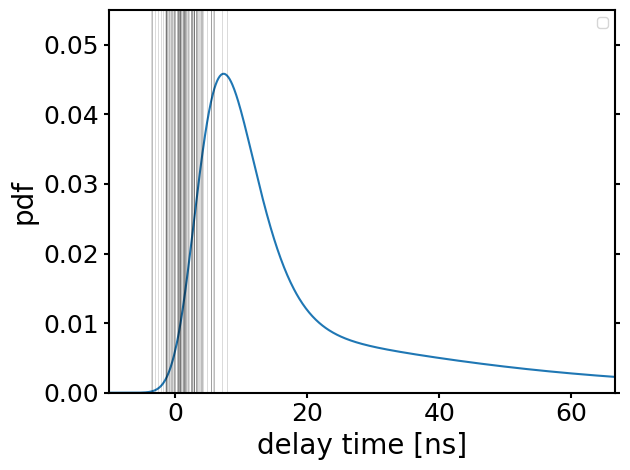

In [266]:
c_multi_gamma_prob_vx = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)

xvals = np.linspace(-10, 3000, 30000)

m = mix_probs[dom_i]
a = av[dom_i]
b = bv[dom_i]
yval = c_multi_gamma_prob_vx(xvals, m, a, b, 2.0, 0.1)
mode = (a[1]-1)/b[1]
fig, ax = plt.subplots()
plt.plot(xvals, yval)
    
plot_args = {'xlim':[-10, np.max([20, 10 * mode])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in times_dict[max_om]:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

250.0
30.0


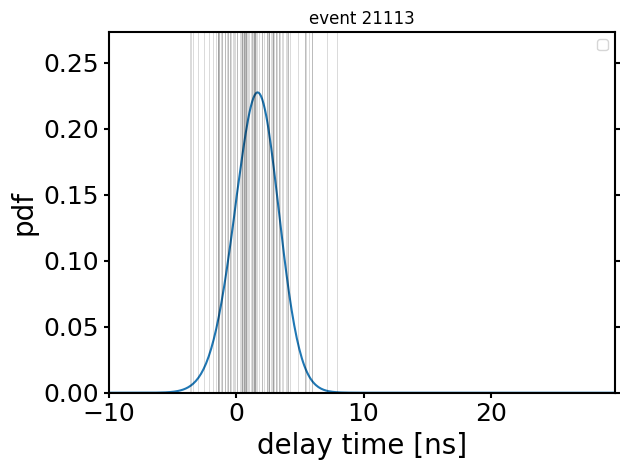

In [269]:
c_multi_gamma_sf_vx = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

n_p = qtot_dict[tuple(np.array(positions_batch[dom_i]))]
n_p = np.round(n_p+0.5)
print(n_p)
n_p = np.min([30.0, n_p])
print(n_p)

m = mix_probs[dom_i]
a = av[dom_i]
b = bv[dom_i]

probs = c_multi_gamma_prob_vx(xvals, m, a, b, 2.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, m, a, b, 2.0)
yval = n_p * probs * sfs**(n_p-1)

mode = (a[1]-1)/b[1]
fig, ax = plt.subplots()
plt.title(f"event {event_ids[ix]}")
plt.plot(xvals, yval)
    
plot_args = {'xlim':[-10, np.max([20, 5 * np.amax(tx)])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in times_dict[max_om]:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

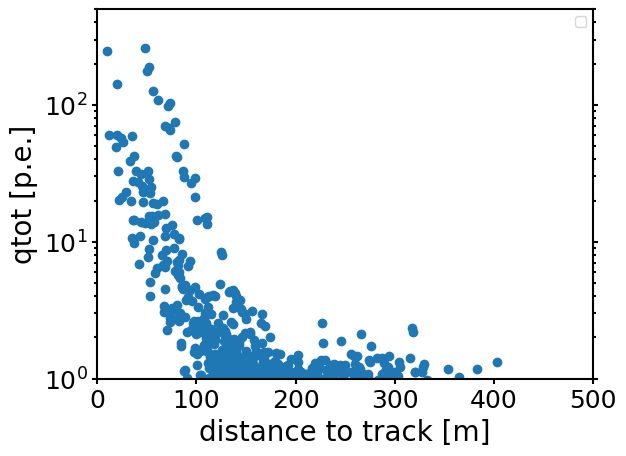

In [270]:
qtots = []
for dom_pos in positions_batch:
    qtots.append(qtot_dict[tuple(np.array(dom_pos))])

fig, ax = plt.subplots()
plt.scatter(closest_approach_dist, qtots)
plot_args = {'xlim':[0.0, 500],
                     'ylim':[0.0, 500],
                     'xlabel':'distance to track [m]',
                     'ylabel':'qtot [p.e.]'}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.ylim([1.0, 500])
plt.show()